In [30]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import glob
import pandas as pd
from scipy.io import arff
import logging
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from tools.clustering.fuzzy_cmeans import FuzzyCMeansParamsGrid
from tools.config import DATA_DIR, CLUSTERED_DATA_DIR

# Set up logger
logger = logging.getLogger(__name__)

In [32]:
CLUSTERED_DATA_DIR
model_name = 'fuzzy_cmeans'
dataset_name = 'synthetic'

In [24]:
SCRIPT_DIR = pathlib.Path(os.getcwd()).absolute()
DATA_DIR = os.path.join(SCRIPT_DIR.parent, "data")
PREPROCESSED_DATA_DIR = f'{DATA_DIR}/1_preprocessed/'

In [25]:
data_path = f"{DATA_DIR}/1_preprocessed/synthetic.csv"
df  = pd.read_csv(data_path)
df['class'].unique()

array([1, 2, 4, 3, 0])

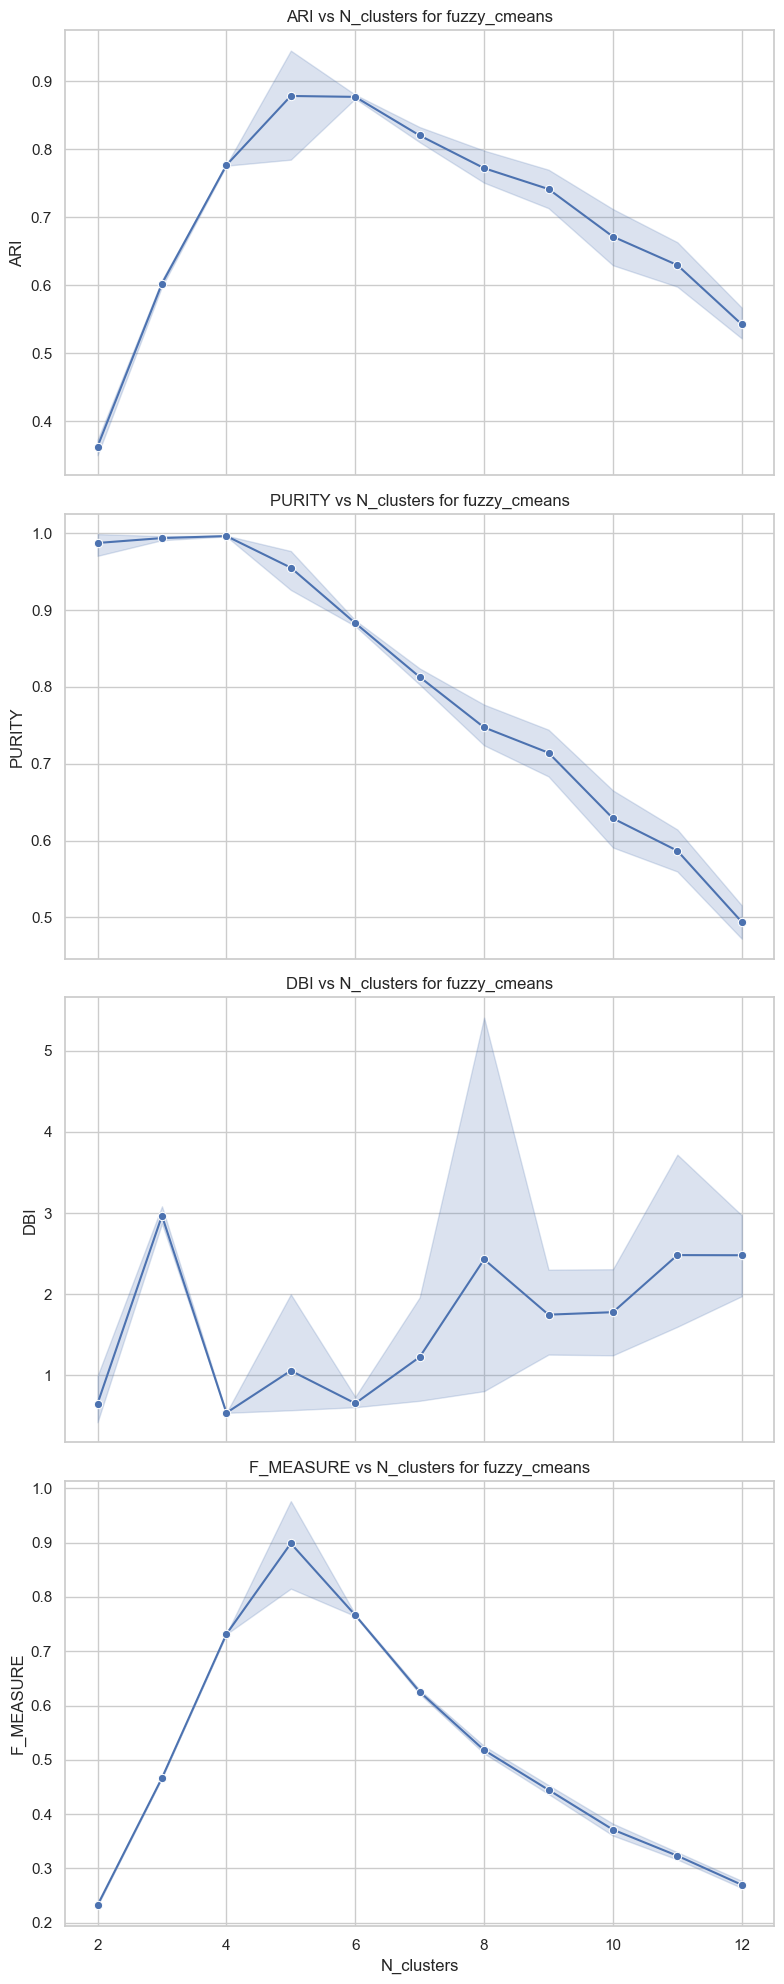

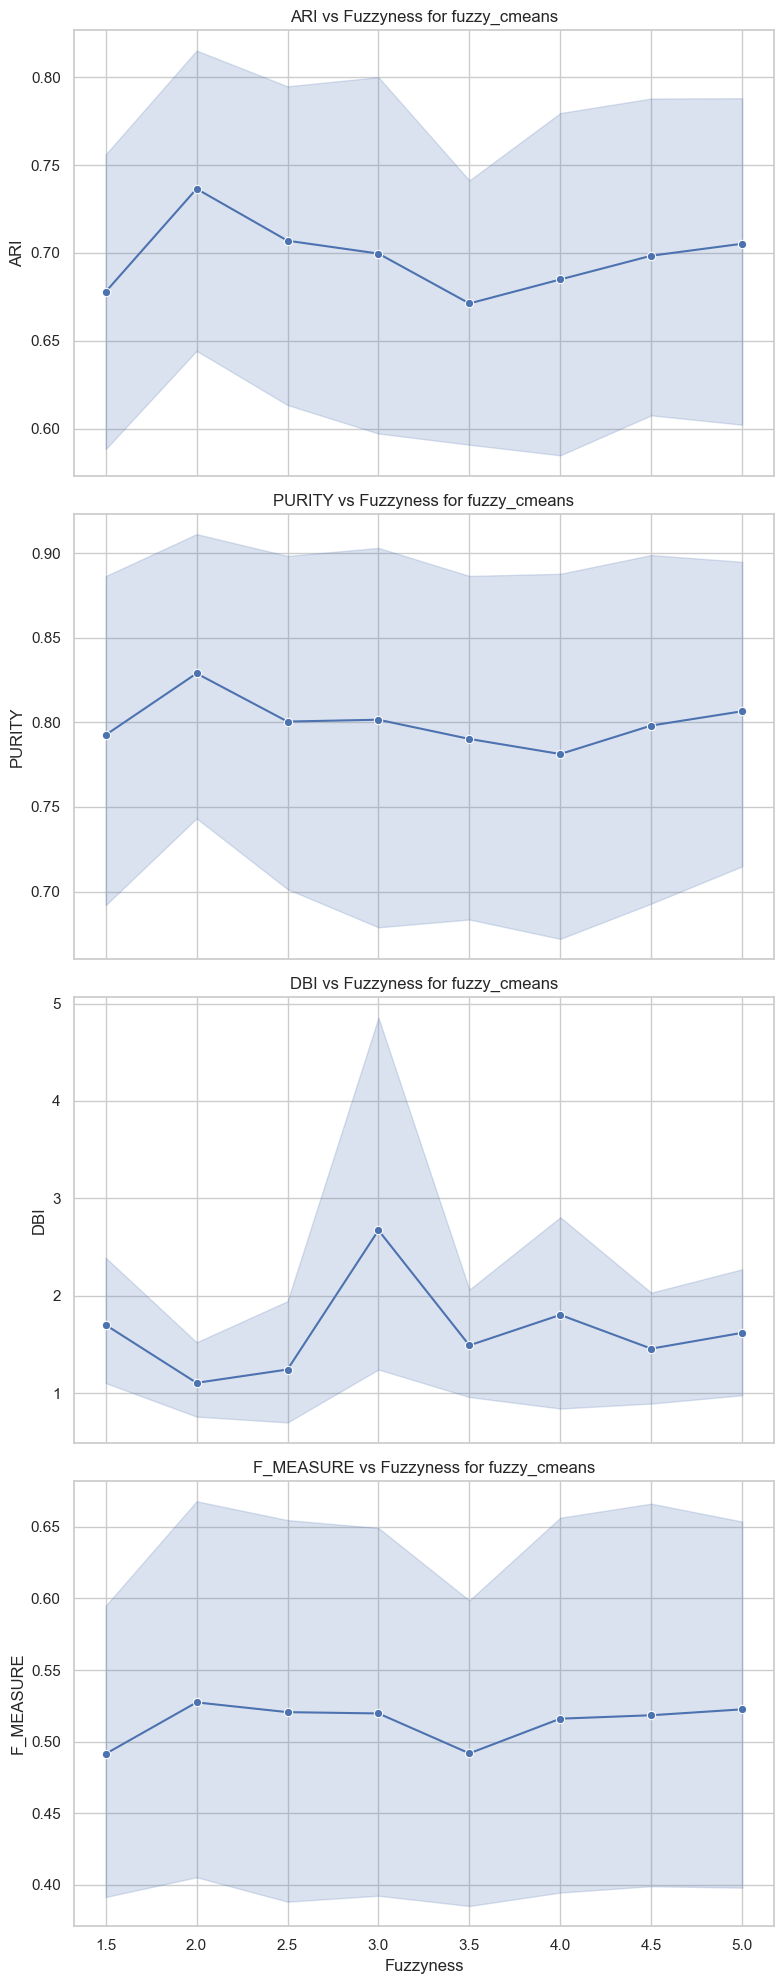

In [81]:
def plot_interactions(csv_path, model_name, paramsGrid):
    """
    Plots interaction plots for various metrics based on a model and parameter grid.

    Parameters:
    - csv_path (str): Path to the metrics CSV file.
    - model_name (str): Name of the model to filter for in the dataset (e.g., 'fuzzy_cmeans').
    - paramsGrid (list of str): List of parameter names to include in the interaction plot (e.g., ['fuzzyness']).

    Returns:
    - None: Displays the interaction plot.
    """
    # Load the data
    data = pd.read_csv(f'{DATA_DIR}/{csv_path}')
    
    # Filter data for the selected model
    data = data[data['model'] == model_name]
    
    # Ensure that the parameters in paramsGrid exist in the dataset
    for param in paramsGrid:
        if param not in data.columns:
            raise ValueError(f"Parameter '{param}' not found in the dataset columns.")
    
    # Set up the plotting style
    sns.set(style="whitegrid")
    
    # Create interaction plots for each parameter in paramsGrid
    metrics = ['ari', 'purity', 'dbi', 'f_measure']  # List of metrics to visualize
    for param in paramsGrid:
        fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 5 * len(metrics)), sharex=True)
        if len(metrics) == 1:  # If only one metric, make axes a list for uniform indexing
            axes = [axes]
        
        # Plot each metric
        for ax, metric in zip(axes, metrics):
            sns.lineplot(
                x=param,
                y=metric,
                data=data,
                marker="o",
                ax=ax
            )
            ax.set_title(f'{metric.upper()} vs {param.capitalize()} for {model_name}')
            ax.set_xlabel(param.capitalize())
            ax.set_ylabel(metric.upper())
        
        plt.tight_layout()
        plt.show()

# Example usage:
csv_path = '3_metrics.csv'
model_name = 'fuzzy_cmeans'
paramsGrid = FuzzyCMeansParamsGrid.keys()  # Example parameter grid
plot_interactions(csv_path, model_name, paramsGrid)


In [27]:
def plot_param_interconnections_from_files(model_name, param_grid, scoring_metric=f1_score):
    """
    Plots parameter interconnections from CSV files in a directory structure.

    Args:
      data_dir: The directory containing the data CSV files.
      model_name: The name of the model (subdirectory within data_dir).
      param_grid: The parameter grid (dictionary) used to generate the files.
      scoring_metric: The scoring metric function to use (default: f1_score).
    """

    # Generate all parameter combinations
    param_combinations = list(ParameterGrid(param_grid))
    n_combinations = len(param_combinations)

    # Get parameter names for plotting
    param_names = list(param_grid.keys())
    if len(param_names) != 2:
        raise ValueError("This function currently supports plotting with 2 parameters.")

    # Initialize arrays to store results
    param1_values = np.zeros(n_combinations)
    param2_values = np.zeros(n_combinations)
    scores = np.zeros(n_combinations)

    # Load data and calculate scores
    for i, params in enumerate(param_combinations):
        # Construct filename from parameters
        filename = f"{param_names[0]}={params[param_names[0]]},{param_names[1]}={params[param_names[1]]}.csv"
        filepath = os.path.join(DATA_DIR, '3_metrics.csv')

        try:
            # Load data from CSV
            df = pd.read_csv(filepath)
            y_true = df['y_true']  # Assuming 'y_true' column exists
            y_pred = df['y_pred']  # Assuming 'y_pred' column exists

            param1_values[i] = params[param_names[0]]
            param2_values[i] = params[param_names[1]]
            scores[i] = scoring_metric(y_true, y_pred, average='macro')

        except FileNotFoundError:
            print(f"Warning: File not found: {filepath}")
            scores[i] = np.nan  # Or handle missing files differently

    # Create the plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with score as color (ignoring NaN values)
    valid_indices = ~np.isnan(scores)
    scatter = ax.scatter(param1_values[valid_indices], param2_values[valid_indices], scores[valid_indices], 
                        c=scores[valid_indices], cmap='viridis')

    # Set labels and title
    ax.set_xlabel(param_names[0])
    ax.set_ylabel(param_names[1])
    ax.set_zlabel(scoring_metric.__name__)
    ax.set_title(f'{model_name} Parameter Interconnections')

    # Add a color bar
    fig.colorbar(scatter, label=scoring_metric.__name__)

    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

def plot_interactions_grid(df, col_names, metrics):
    """
    Plots interaction plots for the specified columns and metrics.
    
    Parameters:
    - df: DataFrame containing the data.
    - col_names: List of column names to include in the grid (e.g., ['fuzzyness', 'n_clusters']).
    - metrics: List of metrics to analyze (e.g., ['ari', 'purity', 'dbi', 'f_measure']).
    
    Returns:
    - fig: The generated matplotlib figure.
    """
    num_cols = len(col_names)
    num_metrics = len(metrics)
    
    # Create subplots grid
    fig, axes = plt.subplots(num_cols, num_cols, figsize=(6 * num_cols, 4 * num_cols))
    
    # If axes is a single subplot, make it iterable
    if num_cols == 1:
        axes = np.array([[axes]])
    elif axes.ndim == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Iterate over the combinations of columns
    for i, ((col_name1, col_name2), ax) in enumerate(zip(itertools.product(col_names, repeat=2), axes.flatten())):
        if col_name1 == col_name2:
            # Diagonal: Plot distribution of each metric for the given column
            sns.boxplot(data=df, x=col_name1, y=metrics[0], ax=ax)
            ax.set_title(f"Distribution of {metrics[0].upper()} by {col_name1.capitalize()}", fontsize=10)
        else:
            # Off-diagonal: Plot interaction heatmap between two columns for each metric
            pivot_table = df.pivot_table(
                values=metrics[0],  # Use the first metric for simplicity
                index=col_name1,
                columns=col_name2,
                aggfunc='mean'
            )
            sns.heatmap(
                pivot_table, 
                ax=ax, 
                cmap='coolwarm', 
                annot=True, 
                fmt='.3f', 
                cbar=False
            )
            ax.set_title(f"Interaction of {col_name1.capitalize()} and {col_name2.capitalize()} on {metrics[0].upper()}", fontsize=10)
        
        # Remove ticks to make plots cleaner
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    # Add row labels for columns
    for i in range(num_cols):
        if axes[i, 0] is not None:  # Ensure this is a valid subplot
            axes[i, 0].set_ylabel(col_names[i], fontsize=14, rotation=90)
        if axes[-1, i] is not None:  # Ensure this is a valid subplot
            axes[-1, i].set_xlabel(col_names[i], fontsize=14, rotation=0)
    
    plt.tight_layout()
    return fig



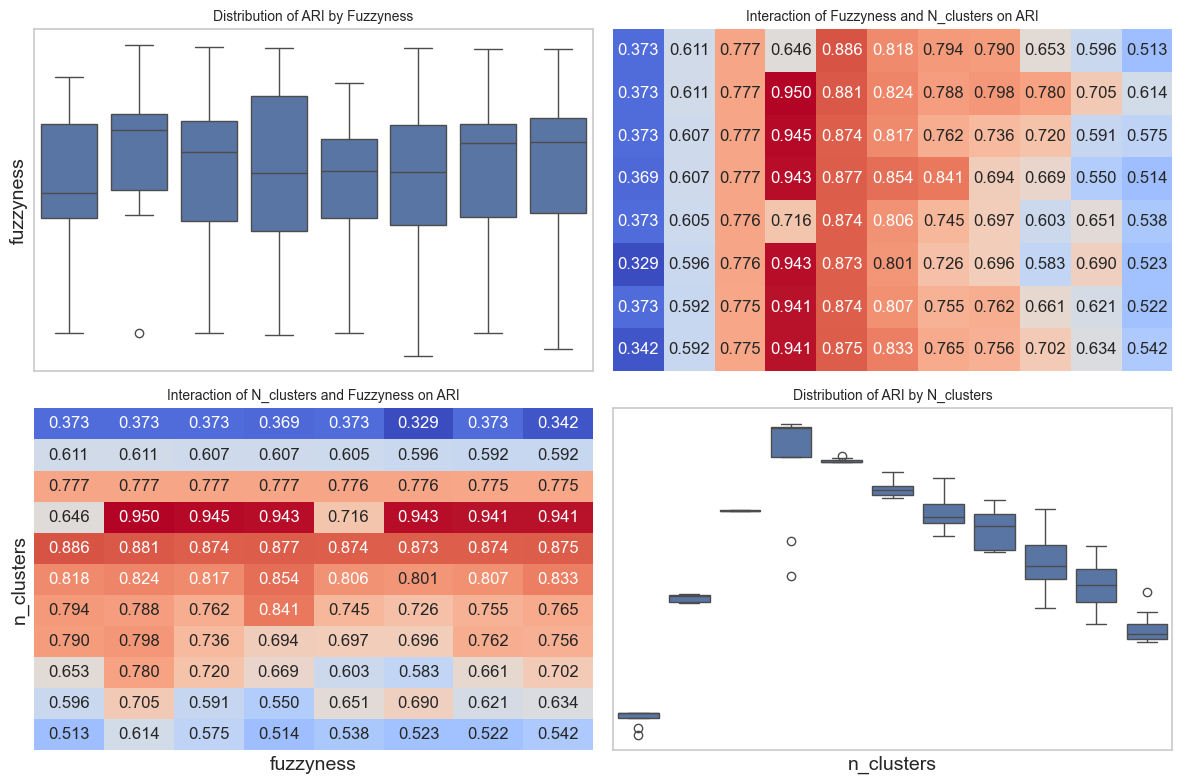

In [ ]:
# Example usage:
# Load metrics data
csv_path = "3_metrics.csv"
df = pd.read_csv(f'{DATA_DIR}/{csv_path}')

# Specify parameters and metrics
col_names = ['fuzzyness', 'n_clusters']
metrics = ['ari', 'purity', 'dbi', 'f_measure']

# Generate plot
fig = plot_interactions_grid(df, col_names, metrics)
plt.show()

In [79]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_clusters(path, features):
    data = pd.read_csv(path)
    config = " ".join(path.split('/')[-1][:-4].split(','))
    labels = data['cluster'].to_list()
    x = str(features[0])
    y = str(features[1])


    plt.figure(figsize=(8, 6))
    plt.scatter(data[x], data[y], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.colorbar()
    plt.title(f'Clusters visualized using {config}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


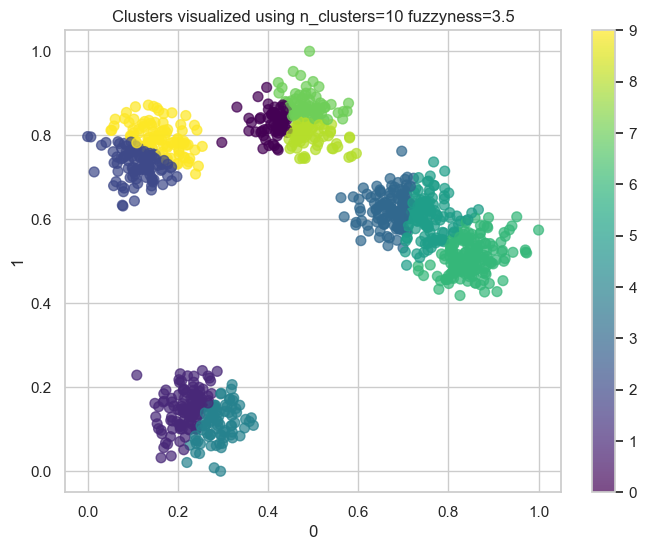

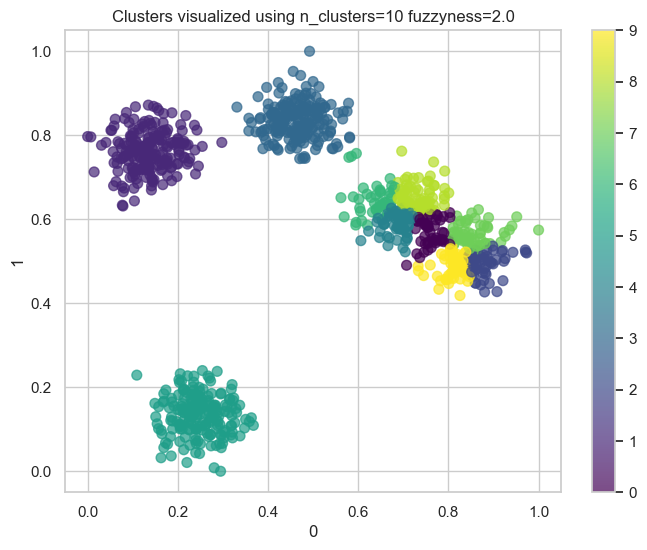

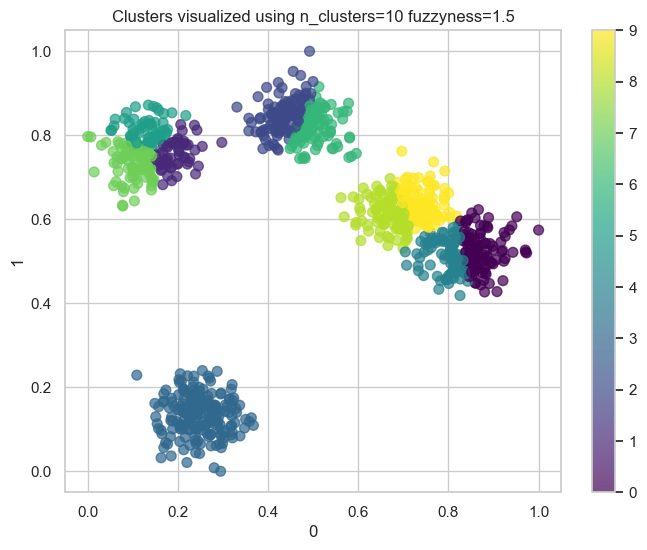

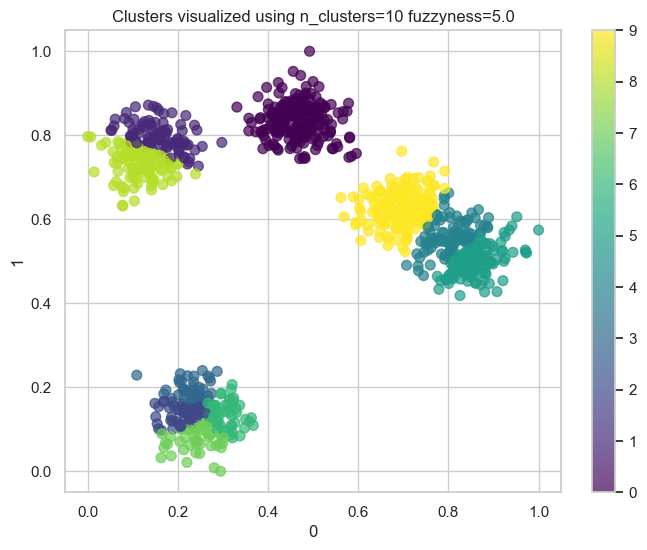

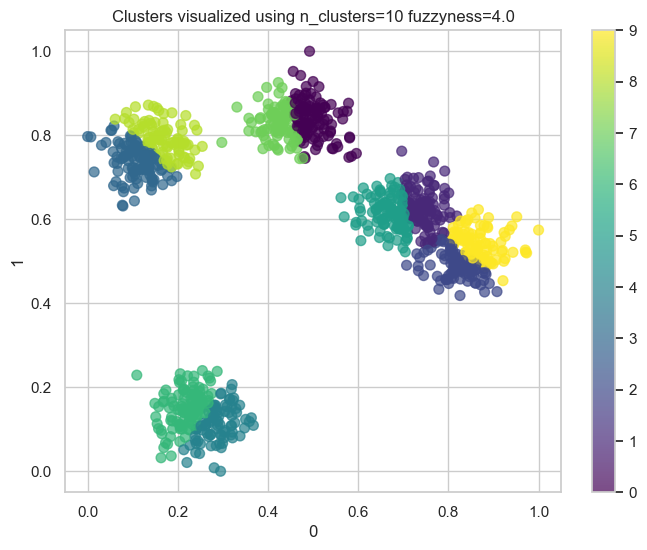

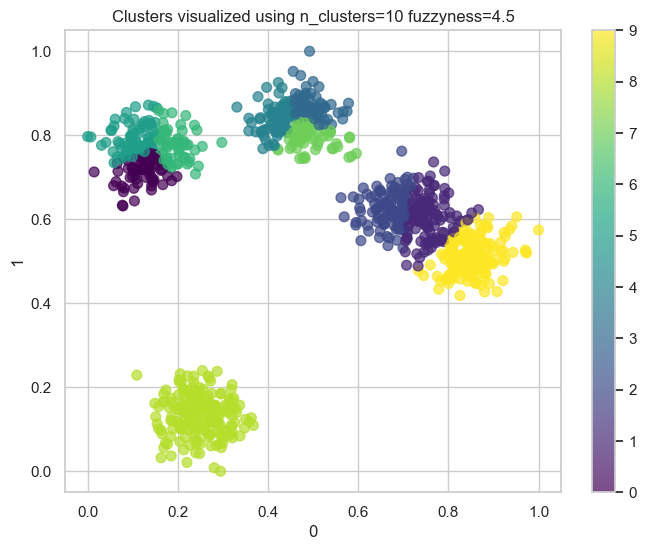

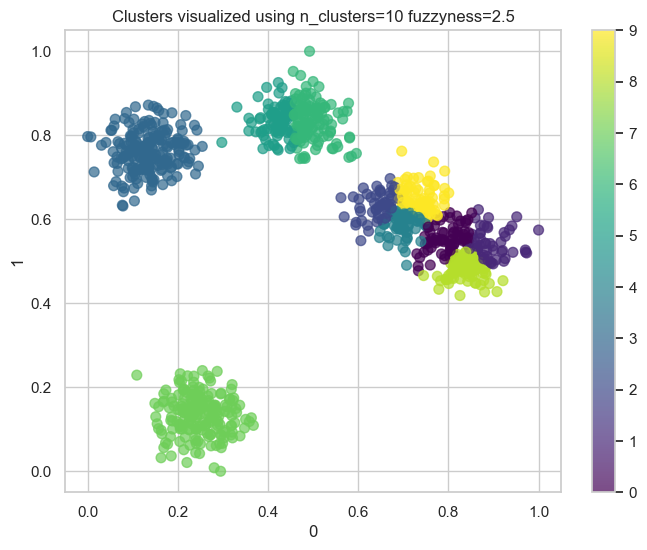

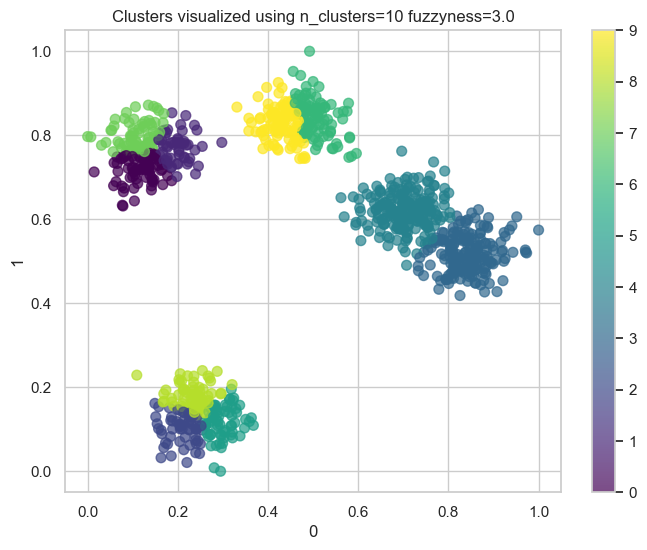

In [80]:
for path in glob.glob(f'{CLUSTERED_DATA_DIR}/{dataset_name}/{model_name}/*'):
    if 'n_clusters=10' in path:
        plot_clusters(path=path, features=['0','1'])



In [ ]:
def plot_metrics_comparison(metrics_dict):
    for metric_name, metric_values in metrics_dict.items():
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(metric_values.keys()), y=list(metric_values.values()))
        plt.title(f'Comparison of {metric_name}')
        plt.xlabel('Algorithm')
        plt.ylabel(metric_name)
        plt.show()